# Compare Summary Tree with True Simulated Tree

In [83]:
from Bio import Nexus, Phylo
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re

/opt/homebrew/Caskroom/miniforge/base/envs/beast-tools/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


In [84]:


def get_branch_info(tree):
    """
    Return a list of (clade_id, branch_length, length_ci_lower, length_ci_upper) tuples.
    If length_range is not present, CI values are set to None.
    """
    branch_info = []
    i = 0
    for clade in tree.find_clades(order='preorder'):
        # Assign a clade ID (tip name or internal node ID)
        if clade.name:
            clade_id = clade.name
        else:
            clade_id = f"internal_{i}"
            i += 1

        # Branch length (from parent to this clade)
        bl = clade.branch_length if clade.branch_length is not None else 0.0

        # Try to extract length_range from clade.comment
        lower_ci, upper_ci = None, None
        if clade.comment:
            match = re.search(r'length_range=\{([\d\.eE+-]+),([\d\.eE+-]+)\}', clade.comment)
            if match:
                lower_ci = float(match.group(1))
                upper_ci = float(match.group(2))

        branch_info.append((clade_id, bl, lower_ci, upper_ci))
    return branch_info

def compare_branch_lengths(tree_sim, tree_constcoal):
    # Extract branch info
    branches_sim = get_branch_info(tree_sim)
    branches_constcoal = get_branch_info(tree_constcoal)

    # Build DataFrame
    branch_length_df = pd.DataFrame({
        "branch": [b1[0] for b1 in branches_sim],
        "length_sim": [b1[1] for b1 in branches_sim],
        "length_constcoal": [b2[1] for b2 in branches_constcoal],
        "ci_lower_constcoal": [b2[2] for b2 in branches_constcoal],
        "ci_upper_constcoal": [b2[3] for b2 in branches_constcoal], 
        "inside_ci": [
            b2[2] <= b1[1] <= b2[3] if b2[2] is not None and b2[3] is not None else None
            for b1, b2 in zip(branches_sim, branches_constcoal)
        ]})
    branch_length_df["difference"] = branch_length_df["length_constcoal"] - branch_length_df["length_sim"]
    branch_length_df['relative_error'] = branch_length_df['difference'] / branch_length_df['length_sim']
    branch_length_df['abs_relative_error'] = np.abs(branch_length_df['relative_error'])

    return branch_length_df

def plot_tree_comparison(branch_length_df):

    # Drop rows with missing or non-positive values (log scale cannot handle <= 0)
    df_log = branch_length_df.dropna(subset=["ci_lower_constcoal", "ci_upper_constcoal"])
    df_log = df_log[(df_log["length_sim"] > 0) & (df_log["length_constcoal"] > 0)]

    # Compute asymmetric error bars for y-axis (const-coal tree)
    yerr_lower = df_log["length_constcoal"] - df_log["ci_lower_constcoal"]
    yerr_upper = df_log["ci_upper_constcoal"] - df_log["length_constcoal"]
    yerr = np.array([yerr_lower, yerr_upper])

    # Determine unified log-space limits
    log_min = df_log[["length_sim", "length_constcoal"]].min().min()
    log_max = df_log[["length_sim", "length_constcoal"]].max().max()
    margin = 0.1  # for padding
    log_min = log_min * (1 - margin)
    log_max = log_max * (1 + margin)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.errorbar(
    df_log["length_sim"],
    df_log["length_constcoal"],
    yerr=yerr,
    fmt='o',
    ecolor='gray',
    color='steelblue',
    markersize=4,
    elinewidth=0.6,
    capsize=3,
    alpha=1,
    label="Branch lengths"
    )

    # Add diagonal x = y line
    x_vals = np.logspace(np.log10(log_min), np.log10(log_max), 100)
    plt.plot(x_vals, x_vals, 'k--')

    # Set log scale
    plt.xscale("log")
    plt.yscale("log")

    # Set same limits and equal aspect ratio
    plt.xlim(log_min, log_max)
    plt.ylim(log_min, log_max)
    plt.gca().set_aspect('equal', adjustable='box')

    # Labels and formatting
    plt.xlabel("Branch length [years] (simulated tree, log scale)")
    plt.ylabel("Branch length [years] (const-coalescent tree, log scale)")
    plt.title("Log-Scaled Branch Length Comparison with Credible Intervals")
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.show()


In [8]:
treepath_sim = "../results/pop_size_simulations/independent_homochronous/uniform/uniform.trees"
tree_sim = next(Phylo.parse(treepath_sim, "newick"))

treepath_constcoal = "../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/uniform/constcoal_homochronous_uniform.T0.tree"
tree_constcoal = next(Phylo.parse(treepath_constcoal, "nexus"))

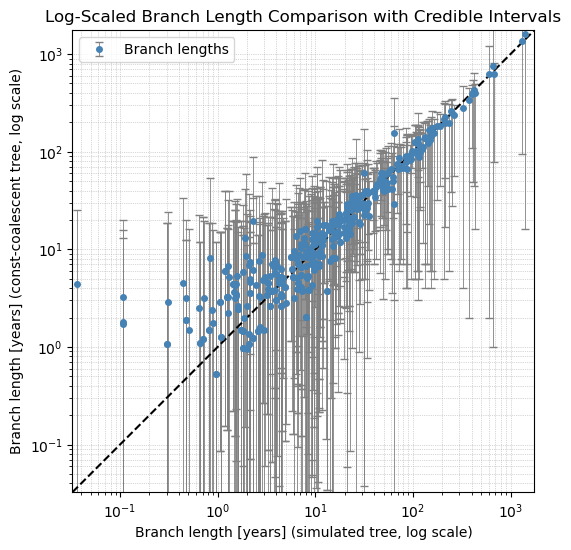

,branch,length_sim,length_constcoal,ci_lower_constcoal,ci_upper_constcoal,inside_ci,difference,relative_error,abs_relative_error
0,internal_0,0.000000,0.000000,NaN,NaN,None,0.000000,NaN,NaN
1,internal_1,1401.340366,1598.597594,16.000000,3663.869894,True,197.257228,0.140763,0.140763
2,internal_2,63.793542,29.222556,0.013347,183.258237,True,-34.570986,-0.541920,0.541920
3,internal_3,112.256347,133.692667,3.000000,250.747468,True,21.436320,0.190959,0.190959
4,internal_4,427.466128,398.627527,16.000000,498.118308,True,-28.838601,-0.067464,0.067464


In [85]:
branch_length_df = compare_branch_lengths(tree_sim, tree_constcoal)
plot_tree_comparison(branch_length_df)
branch_length_df.head()

In [86]:
print(f"Percentage of esitmates inside CI: {branch_length_df['inside_ci'].sum() / len(branch_length_df) * 100} %")

Percentage of esitmates inside CI: 99.74937343358395 %


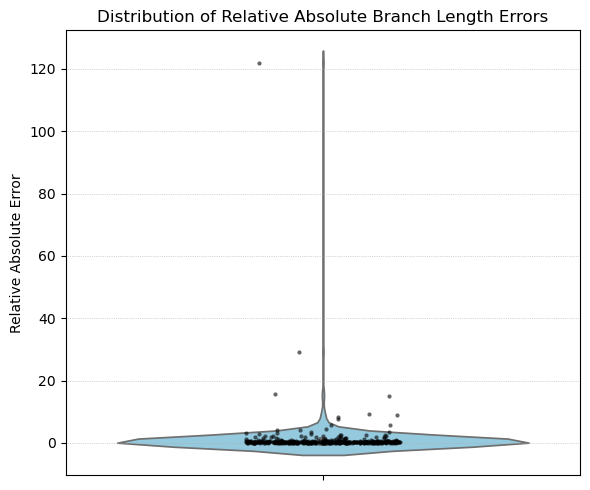

In [89]:
# Drop any NaNs (e.g. from division by zero)
df_violin = branch_length_df.dropna(subset=['abs_relative_error'])

# Plot violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(y=df_violin['abs_relative_error'], inner="box", color="skyblue")

# Add individual points (with jitter)
sns.stripplot(
    y='abs_relative_error',
    data=df_violin,
    color='black',
    size=3,
    alpha=0.6,
    jitter=0.15
)

plt.title("Distribution of Relative Absolute Branch Length Errors")
plt.ylabel("Relative Absolute Error")
plt.xlabel("")
plt.grid(True, axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

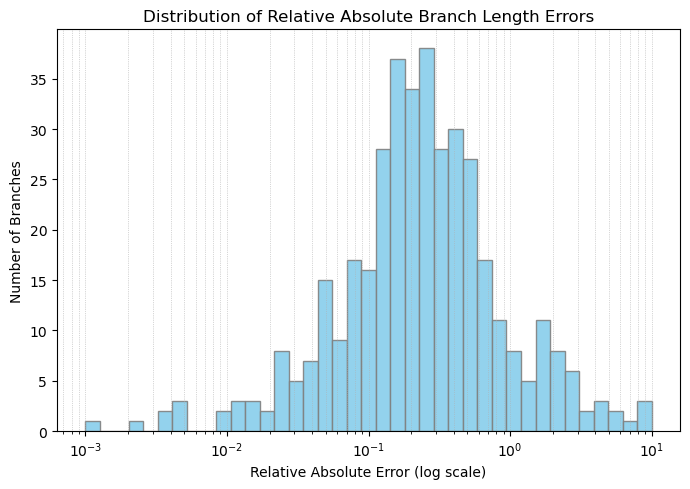

In [90]:
# Plot histogram with log x-axis
plt.figure(figsize=(7, 5))
plt.hist(branch_length_df['abs_relative_error'], bins=np.logspace(-3, 1, 40), color='skyblue', edgecolor='gray', alpha=0.9)

plt.xscale('log')
plt.xlabel("Relative Absolute Error (log scale)")
plt.ylabel("Number of Branches")
plt.title("Distribution of Relative Absolute Branch Length Errors")
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [91]:
# relative error
np.abs(branch_length_df['relative_error']).describe()

# Outliers steering error

count    398.000000
mean       1.010940
std        6.429095
min        0.000520
25%        0.121289
50%        0.231004
75%        0.489077
max      122.003045
Name: relative_error, dtype: float64

In [81]:
np.abs(branch_length_df['difference']).describe()

count    399.000000
mean       6.048769
std       13.414403
min        0.000000
25%        1.296347
50%        3.032439
75%        6.266887
max      197.257228
Name: difference, dtype: float64